In [387]:
from __future__ import print_function, division
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time
import os
import copy
import sys

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import urllib.request as urllib2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATASET_PATH = './Dataset/'

In [388]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [1]:
classes = ('aeroplane','bicycle','diningtable',
           'dog','horse','motorbike','person','pottedplant','sheep','train','tvmonitor',
           'bird','boat','bottle','bus','car','cat','chair','cow')

In [390]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [391]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [392]:
model = models.vgg16(pretrained=False)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=len(classes))
model = model.to(device)

In [393]:
model.load_state_dict(torch.load('./TrainedModel/PretrainedTrue'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [394]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

In [395]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            for i in outputs:
                print(i)
            _, preds = torch.max(outputs, 1)
            
            print(preds.size)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, {}'.format(classes[preds[j]], preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            
        model.train(mode=was_training)

tensor([-2.4635, -7.0219, -1.9950, -3.2368, -6.0101, -5.0109, -1.8395,  0.3869,
        -1.8774,  8.2758, -1.8477, -1.0541, -0.1821, 10.9022,  7.5684,  1.1380,
         2.0165, -1.0599,  8.5235, -5.0227], device='cuda:0')
tensor([-4.6884, -6.5867, -2.9028,  8.1836,  6.6240, -5.8434,  1.1809, -2.9305,
        23.2839, -3.4584, -6.7053, -4.7022,  1.5119, -5.7577, -3.6638, -5.9466,
        -4.8483,  3.9933, -5.0942, 18.5186], device='cuda:0')
tensor([-3.1509, -0.8747, -1.9204,  8.1627,  3.3190, -2.2999,  1.6921, -1.1249,
         6.1394, -1.3984, -3.4046, -2.9592,  2.3154, -3.1717, -1.2407, -3.0884,
        -2.5790,  6.2534, -1.1042,  1.1401], device='cuda:0')
tensor([53.4898,  6.1650, -3.5475, -4.7692, -6.9818, -1.2590, -1.9522, -9.2441,
        -8.1612, -7.2879, -3.0811, -1.8217, 17.9253,  0.3440, -4.3034, -6.0000,
        -1.5476, -7.2700, -1.3684, -5.3414], device='cuda:0')
<built-in method size of Tensor object at 0x7fb7e61539d8>


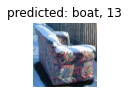

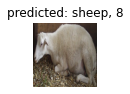

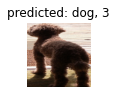

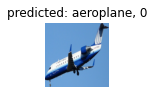

tensor([-12.4244,   1.8390,  -3.2079,  -0.9728,  -7.1823,  -3.2214,  12.3954,
          0.4742,  -4.0558,  -3.8461,  -2.1406,   1.7370,  -2.4469,  -1.2137,
         46.6260,  -3.6286,  -4.8781,  -3.2554,   5.0204, -12.0194],
       device='cuda:0')
tensor([ -4.4353,  -4.4382,  -5.1188,   9.8797,  -1.5779,  -2.1555,  42.1754,
         -1.3818,  -7.4263,   4.1999, -10.1104,  -7.2388,   6.3923,  -3.7803,
          4.0337, -11.2474,  -9.7874,  -2.6041,   9.4102,  -3.0350],
       device='cuda:0')
tensor([-2.3371, -3.7269, -4.2033,  4.1732,  3.0040, -5.4079,  0.7910, -2.8987,
        19.7436, -6.6073, -5.4490, -4.0603,  7.1270, -3.5200,  1.6791, -4.0785,
        -0.2818,  0.0656, -3.0697, 10.0620], device='cuda:0')
tensor([-6.8016e+00, -9.9982e+00,  7.1306e+00, -1.0115e+01, -1.2436e+01,
        -1.3328e+01,  8.6047e-02,  2.7857e+00, -6.5001e+00, -8.0556e-01,
        -9.3720e-02,  4.7627e+01, -8.8959e+00, -9.1976e-01,  3.8527e+00,
         5.0335e+00,  1.0468e-02, -1.0053e-01,  1.2665e+01, -

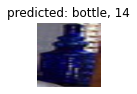

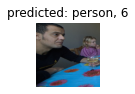

In [396]:
visualize_model(model)

In [397]:
def cv2_selective_search(img, searchMethod='f'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    
    if searchMethod == 'f':
        ss.switchToSelectiveSearchFast()
    elif searchMethod == 'q':
        ss.switchToSelectiveSearchQuality()
        
    regions = ss.process()
    
    return regions

In [398]:
def draw_bounding_box(bounding_box, img):
    tmp_img = img.copy()

    dim = np.array(bounding_box).ndim
    
    if dim == 2:
        for x, y, w, h in bounding_box:
            cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    elif dim == 3:
        for bb in bounding_box:
            for x, y, w, h in bb:
                cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

In [399]:
def get_predict_result(probs):
    predict_score, predict_class = torch.max(probs, 1)
    return predict_score, predict_class

In [400]:
def get_predict(model, img):
    model.eval()
    
    with torch.no_grad():
        inputs = img.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        softmax = nn.Softmax(dim=1)
        outputs = softmax(outputs)
        #print(outputs)
        return outputs
        #predict_score, predict_class = torch.max(outputs, 1)
        #print(predict_score)
        #print(predict_class)
        #return(predict_score, predict_class)

### IMG_URL 사용할 경우

In [401]:
IMG_URL = "https://www.sciencemag.org/sites/default/files/styles/inline__450w__no_aspect/public/dogs_1280p_0.jpg?itok=4t_1_fSJ"

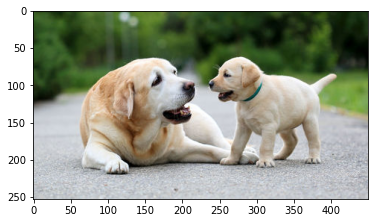

In [402]:

img = Image.open(urllib2.urlopen(IMG_URL))

opencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))

In [403]:
_img = img
_img = data_transforms['test'](transforms.ToPILImage()(np.asarray(_img)))
probs = get_predict(model, _img)
print(probs.tolist()[0][1])
get_predict_result(probs)

4.026067673690292e-11


(tensor([0.9505], device='cuda:0'), tensor([9], device='cuda:0'))

### Image.open 사용할 경우

In [32]:
"""
img = Image.open(DATASET_PATH+'sample/bicycle_2.jpg')

opencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))

_img = img
_img = data_transforms['test'](transforms.ToPILImage()(np.asarray(_img)))
get_predict(model, _img)
"""

"\nimg = Image.open(DATASET_PATH+'sample/bicycle_2.jpg')\n\nopencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)\n\nplt.imshow(cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))\n\n_img = img\n_img = data_transforms['test'](transforms.ToPILImage()(np.asarray(_img)))\nget_predict(model, _img)\n"

num of all regions by ss: 719


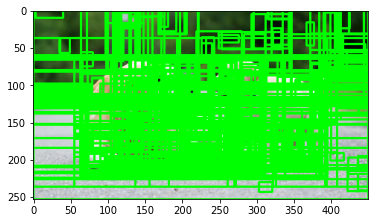

In [404]:
SS_BB = cv2_selective_search(opencvImg)

print(f'num of all regions by ss: {len(SS_BB)}')
plt.imshow(draw_bounding_box(SS_BB, opencvImg))

In [405]:
def get_candidate_bounding_box(SS_BB, max_cnt = 1000):
    bounding_box = []
    
    for index, ss_bb in enumerate(SS_BB):
        if index < max_cnt:
            bounding_box.append(ss_bb)
    return bounding_box

In [406]:
MAX_BOX_CNT = 100

In [407]:
bounding_box = get_candidate_bounding_box(SS_BB, MAX_BOX_CNT)

In [408]:
det_probs = []

for index, (x, y, w, h) in enumerate(bounding_box):
    area = (x, y, x + w, y + h)
    timage = img.crop(area)
    timage = data_transforms['test'](transforms.ToPILImage()(np.asarray(timage)))
    prob = get_predict(model, timage)
    det_probs.append(prob.tolist()[0])
    
det_probs = torch.as_tensor(det_probs)
print(det_probs.shape)
print(det_probs)

torch.Size([100, 20])
tensor([[6.9420e-05, 1.2452e-04, 1.3712e-02,  ..., 1.7769e-03, 1.6584e-01,
         6.4523e-03],
        [1.8255e-04, 2.5817e-04, 6.4535e-03,  ..., 8.8554e-03, 3.0643e-02,
         2.4962e-02],
        [5.6760e-10, 1.8888e-09, 2.2409e-08,  ..., 5.3850e-05, 6.9504e-07,
         1.6369e-06],
        ...,
        [8.8362e-06, 7.3813e-06, 1.8119e-05,  ..., 2.6897e-05, 2.3710e-04,
         2.7720e-02],
        [1.0390e-03, 1.4010e-04, 2.9721e-06,  ..., 9.4261e-03, 4.0040e-05,
         1.8667e-03],
        [1.3149e-04, 6.1601e-05, 1.0031e-02,  ..., 6.4059e-01, 8.3631e-03,
         6.6247e-03]])


In [409]:
def get_iou(_bb1, _bb2, changeScale = False):
    if changeScale:
        # _bb1, _bb2 = [x, y, w, h]
        if len(_bb1) == 4 and len(_bb2) == 4:
            bb1 = {'x1':_bb1[0], 'y1':_bb1[1], 'x2':_bb1[0]+_bb1[2], 'y2':_bb1[1]+_bb1[3]}
            bb2 = {'x1':_bb2[0], 'y1':_bb2[1], 'x2':_bb2[0]+_bb2[2], 'y2':_bb2[1]+_bb2[3]}
        else:
            exit(0)
    else:
        # _bb1, _bb2 = ['x1':x1, 'x2':x2, 'y1':y1, 'y2':y2]
        x1, y1, x2, y2 = _bb1
        bb1 = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
        x1, y1, x2, y2 = _bb2
        bb2 = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [410]:
def nms(bounding_box, probs):
    
    bbox = []

    for x, y, w, h in bounding_box:
        bbox.append([x,y, x+w, y+h])
    
    
    _opencvImg = opencvImg.copy()
    bbox = torch.as_tensor(bbox).float()
    probs = torch.as_tensor(probs)
    for c in range(len(classes)):
        
        _cnt = 0
        
        # threshold 적용
        
        prob = probs[:, c].clone()
        
        m = nn.Threshold(0.2, 0)
        
        prob = m(prob)
        
        order = torch.argsort(prob, descending=True)
        
        for i in range(len(order)):
            printProgressBar (i, len(order), prefix = f'class {c}', suffix = 'complete', length = 50)
            bbox_max = bbox[order[i]]
            for j in range(i+1, len(order)):
                bbox_cur = bbox[order[j]]
                if get_iou(bbox_max, bbox_cur) > 0.5:
                    prob[order[j]] = 0
        
        printProgressBar (len(order), len(order), prefix = f'class {c}', suffix = 'complete', length = 50)
        probs[:, c] = prob
        """
        
        keep = torchvision.ops.nms(bbox, prob, 0.6)
        
        for i in range(len(keep)):
            if not keep[i]:
                prob[i] = 0.0
            else:
                _cnt += 1
        
        print(_cnt)
        probs[:,c] = prob
        
        """
    
    draw = 0
        
        
    for cnt in range(len(bbox)):
        
        cls_idx = torch.argsort(probs[cnt, :], descending=True)[0]
        
        if probs[cnt][cls_idx] > 0:
            draw += 1
            x,y,w,h = bbox[cnt]
            _opencvImg = cv2.rectangle(_opencvImg, (x, y,), (x+w, y+h), (0, 255, 0), 2)
            text = '{} ({})'.format(classes[cls_idx], probs[cnt][cls_idx])
            cv2.putText(_opencvImg, text, (x, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) 
            
    plt.imsave("result.jpg",cv2.cvtColor(_opencvImg, cv2.COLOR_BGR2RGB))
    
    print(draw)
    
    return 

In [411]:
nms(bounding_box, det_probs)

class 0 |██████████████████████████████████████████████████| 100.0% complete
class 1 |██████████████████████████████████████████████████| 100.0% complete
class 2 |██████████████████████████████████████████████████| 100.0% complete
class 3 |██████████████████████████████████████████████████| 100.0% complete
class 4 |██████████████████████████████████████████████████| 100.0% complete
class 5 |██████████████████████████████████████████████████| 100.0% complete
class 6 |██████████████████████████████████████████████████| 100.0% complete
class 7 |██████████████████████████████████████████████████| 100.0% complete
class 8 |██████████████████████████████████████████████████| 100.0% complete
class 9 |██████████████████████████████████████████████████| 100.0% complete
class 10 |██████████████████████████████████████████████████| 100.0% complete
class 11 |██████████████████████████████████████████████████| 100.0% complete
class 12 |██████████████████████████████████████████████████| 100.0% compl

In [199]:
_opencvImg = opencvImg.copy()

bounding_box = torch.as_tensor(bounding_box).float()
det_probs = torch.as_tensor(det_probs).float()
det_class = torch.as_tensor(det_class).float()

final_bbox = []
final_probs = []
final_cls_idx = []

deleted_bbox = []
deleted_probs = []
deleted_cls_idx = []

bbox = []

for x, y, w, h in bounding_box:
    bbox.append([x,y, x+w, y+h])
    
bbox = torch.as_tensor(bbox).float()
    
for c in range(len(classes)):
    idx_per_class = [i for i in range(len(det_probs)) if det_class[i] == c]
    keep = torchvision.ops.nms(bbox[idx_per_class], det_probs[idx_per_class], 0.1)
    
    for i in range(len(keep)):
        if keep[i]:
            final_bbox.append(bounding_box[idx_per_class[i]])
            final_probs.append(det_probs[idx_per_class[i]])
            final_cls_idx.append(c)
        else:
            deleted_bbox.append(bounding_box[idx_per_class[i]])
            deleted_probs.append(det_probs[idx_per_class[i]])
            deleted_cls_idx.append(c)

for bbox, prob, cls_idx in zip(deleted_bbox, deleted_probs, deleted_cls_idx):
    if classes[cls_idx] == 'dog':
        print(prob)
    x,y,w,h = bbox
    _opencvImg = cv2.rectangle(_opencvImg, (x, y,), (x+w, y+h), (225, 0, 0), 2)
    text = '{} ({})'.format(classes[cls_idx], prob)
    cv2.putText(_opencvImg, text, (x, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2) 
             

for bbox, prob, cls_idx in zip(final_bbox, final_probs, final_cls_idx):
    #print(bbox, prob, cls_idx)
    x,y,w,h = bbox
    _opencvImg = cv2.rectangle(_opencvImg, (x, y,), (x+w, y+h), (0, 255, 0), 2)
    text = '{} ({})'.format(classes[cls_idx], prob)
    cv2.putText(_opencvImg, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

print(len(bounding_box), len(final_bbox))

#cv2.imsave(opencvImg)
plt.imsave("result.jpg",cv2.cvtColor(_opencvImg, cv2.COLOR_BGR2RGB))

tensor(0.9999)
50 31
